In [1]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingClassifier


warnings.filterwarnings("ignore")
randomseed = 7

Using TensorFlow backend.


1.Read the dataset and preprocess
======

In [2]:
x_original = pd.read_csv("../../XLable_onlyDiabeticRemoved.txt")

conditions = [
    (x_original.L100800 < 100),
    (x_original.L100800 >= 100) & (x_original.L100800 < 126),
    (x_original.L100800 >= 126),
]
choices = [0, 1, 2]
x_original["CLASS"] = np.select(conditions, choices, default=0)
x_original=x_original [['Unnamed: 0','AGE','SEX','FIELD_31','FIELD_40','S000300',
                       'FIELD_16','FIELD_23','FIELD_15','FIELD_22','FIELD_17','FIELD_24'
                       ]]

In [3]:
y_original = pd.read_csv("../../TargetLable_onlyDiabeticRemoved.txt")

conditions = [
    (y_original.L100800 < 100),
    (y_original.L100800 >= 100) & (y_original.L100800 < 126),
    (y_original.L100800 >= 126),
]

choices = [0, 1, 2]
y_original["CLASS"] = np.select(conditions, choices, default=0)

y_original=y_original[['Unnamed: 0','CLASS' ]]

In [4]:
data = pd.merge(
    x_original, y_original, how="inner", left_on="Unnamed: 0", right_on="Unnamed: 0"
)

In [5]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

# data = data[
#     data.FIELD_15 != 1
# ]  # exclude people who are diagnosed for (high blood pressure)
# data = data[
#     data.FIELD_22 != 1
# ]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia


print(data.shape)

(181880, 13)


In [6]:
data=data.dropna()
print(data.shape)
data=data[['AGE','SEX','FIELD_31','FIELD_15','FIELD_40','S000300','CLASS']]
data.head()

(180763, 13)


,AGE,SEX,FIELD_31,FIELD_15,FIELD_40,S000300,CLASS
0,44.0,1.0,1.0,0.0,0.0,20.1,0
1,45.0,1.0,0.0,0.0,1.0,19.7,0
2,46.0,1.0,0.0,0.0,1.0,20.2,0
3,50.0,1.0,0.0,0.0,0.0,24.7,0
4,51.0,1.0,1.0,0.0,0.0,24.8,0


In [7]:
data.groupby(by='CLASS').size()

CLASS
0    121665
1     55403
2      3695
dtype: int64

2.Downsample the majority class and upsample the minority
===

In [8]:
diabetic = data[data.CLASS == 2]
prediabetic = data[data.CLASS == 1]
normal = data[data.CLASS == 0]

print(diabetic.shape[0], prediabetic.shape[0], normal.shape[0])

3695 55403 121665


In [9]:
diabetic_test = diabetic.sample(200, random_state=randomseed)
prediabetic_test = prediabetic.sample(200, random_state=randomseed)
normal_test = normal.sample(200, random_state=randomseed)
test = pd.concat([diabetic_test, prediabetic_test, normal_test])

diabetic_train = diabetic.drop(diabetic_test.index)
prediabetic_train = prediabetic.drop(prediabetic_test.index)
# .sample(
#     10 * diabetic_train.shape[0], random_state=randomseed
# )
normal_train = normal.drop(normal_test.index).sample(
    prediabetic_train.shape[0]
#     10 * diabetic_train.shape[0], random_state=randomseed
)
train = pd.concat([diabetic_train, diabetic_train, prediabetic_train, normal_train])

In [10]:

xtrain = train.iloc[:, :-1]
ytrain = train.iloc[:, -1]
xtest = test.iloc[:, :-1]
ytest = test.iloc[:, -1]



In [11]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
xtrain=scaler.fit_transform(xtrain)
xtest=scaler.transform(xtest)


In [12]:
from imblearn.over_sampling import SMOTE,SMOTENC  # doctest: +NORMALIZE_WHITESPACE
randomseed=42

sm = SMOTENC(random_state=randomseed,categorical_features=[4],sampling_strategy='minority')
X_res, y_res = sm.fit_resample(xtrain, ytrain)

print("Resampled dataset shape %s" % Counter(y_res))
print(
    y_res[y_res == 0].shape[0], y_res[y_res == 1].shape[0], y_res[y_res == 2].shape[0]
)
print(X_res.shape, y_res.shape)

xtrain = X_res
ytrain = y_res


Resampled dataset shape Counter({2: 55203, 1: 55203, 0: 55203})
55203 55203 55203
(165609, 6) (165609,)


3.Generate the classifier models based on the selected 12 features
====

3.1 Random forest

In [13]:
#hyperparamter serach using grid search
parameters = {'max_features':('auto', 'sqrt','log2'), 'n_estimators':[10,50,100,150,200,300,700]}
rf_clf = RandomForestClassifier()
rf_clf = GridSearchCV(rf_clf, parameters)
rf_clf.fit(xtrain, ytrain)
rf_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:

rf = RandomForestClassifier(
    random_state=randomseed,
    n_estimators=100, 
    max_depth=12,
    min_samples_split=3,
    min_samples_leaf=10,
    max_features="auto",
)

# rf=rf_clf.best_estimator_
# RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#                        max_depth=None, max_features='auto', max_leaf_nodes=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=1, min_samples_split=2,
#                        min_weight_fraction_leaf=0.0, n_estimators=700,
#                        n_jobs=None, oob_score=False, random_state=None,
#                        verbose=0, warm_start=False)


rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
# cross validation test for the model

scores = model_selection.cross_val_score(rf, xtrain, ytrain,cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s] \n [%s]" % (scores.mean(), scores.std(), 'RandomForestClassifier',scores))

0.495


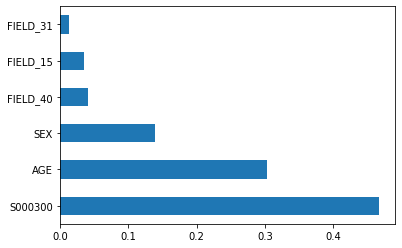

Index(['S000300', 'AGE', 'SEX', 'FIELD_40', 'FIELD_15', 'FIELD_31'], dtype='object')


In [22]:
# Test the performance of the model using the test data
ypred = rf.predict(xtest)

score = rf.score(xtest, ytest)
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:, :-1].columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)

In [23]:
print("Accuracy on training set: {:.3f}".format(rf.score(xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(rf.score(xtest, ytest)))

confmatrx = pd.DataFrame(m.confusion_matrix(ytest, ypred))
confmatrx.head()

Accuracy on training set: 0.611
Accuracy on test set: 0.495


,0,1,2
0,124,52,24
1,47,70,83
2,20,77,103


In [24]:
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.65      0.62      0.63       200
           1       0.35      0.35      0.35       200
           2       0.49      0.52      0.50       200

    accuracy                           0.49       600
   macro avg       0.50      0.49      0.50       600
weighted avg       0.50      0.49      0.50       600



3.2. XGBOOST 

In [14]:
parameters = {'max_depth':[3,5,7,9],
              'n_estimators':[10,50,100,200,700]}
xgb_clf = xgb.XGBClassifier()
xgb_clf = GridSearchCV(xgb_clf, parameters)
xgb_clf.fit(xtrain, ytrain)
xgb_clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=700, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [25]:
xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=randomseed)
# objective="multi:softmax"
# objective="binary:logistic"
# objective='multi:softprob'


# xgb_model=xgb_clf.best_estimator_

xgb_model.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
scores = model_selection.cross_val_score(xgb_model, xtrain, ytrain, 
                                          cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s] \n [%s]" 
      % (scores.mean(), scores.std(), 'xgb_model',scores))

In [26]:
y_pred = xgb_model.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

accuracy 	 0.51


,0,1,2
0,123,47,30
1,51,52,97
2,19,50,131


In [27]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.61      0.63       200
           1       0.35      0.26      0.30       200
           2       0.51      0.66      0.57       200

    accuracy                           0.51       600
   macro avg       0.50      0.51      0.50       600
weighted avg       0.50      0.51      0.50       600



3.3 SVM 

In [15]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1,5,10,15,20,25,30,70]}
SVC_clf = SVC()
SVC_clf2 = GridSearchCV(SVC_clf, parameters)
SVC_clf2.fit(xtrain, ytrain)
SVC_clf2.best_estimator_

SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [28]:
# SVC_clf = SVC_clf2.best_estimator_
SVC_clf=SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
SVC_clf.fit(xtrain, ytrain)

SVC(C=30, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
scores = model_selection.cross_val_score(SVC_clf, xtrain, ytrain, 
                                          cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s] \n [%s]" 
      % (scores.mean(), scores.std(), 'SVC_clf',scores))

In [29]:
y_pred = SVC_clf.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

accuracy 	 0.48333333333333334


,0,1,2
0,90,82,28
1,25,74,101
2,13,61,126


In [30]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.45      0.55       200
           1       0.34      0.37      0.35       200
           2       0.49      0.63      0.55       200

    accuracy                           0.48       600
   macro avg       0.51      0.48      0.49       600
weighted avg       0.51      0.48      0.49       600



3.4 logistic regression

In [31]:
lr=LogisticRegression(random_state=0)
lr.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
y_pred = lr.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

accuracy 	 0.515


,0,1,2
0,139,34,27
1,59,41,100
2,24,47,129


In [33]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.69      0.66       200
           1       0.34      0.20      0.25       200
           2       0.50      0.65      0.57       200

    accuracy                           0.52       600
   macro avg       0.49      0.52      0.49       600
weighted avg       0.49      0.52      0.49       600



3.5 KNN

In [34]:
neigh = KNeighborsClassifier(n_neighbors=150)
neigh.fit(xtrain, ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=150, p=2,
                     weights='uniform')

In [35]:
y_pred = neigh.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

accuracy 	 0.5


,0,1,2
0,119,41,40
1,51,67,82
2,18,68,114


In [36]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.59      0.61       200
           1       0.38      0.34      0.36       200
           2       0.48      0.57      0.52       200

    accuracy                           0.50       600
   macro avg       0.50      0.50      0.50       600
weighted avg       0.50      0.50      0.50       600



3.6 stacking classifier

In [37]:
lr2 = LogisticRegression()
temprf=RandomForestClassifier(n_estimators=500, random_state=42)
temprf2=RandomForestClassifier()
tempsvC= SVC()

estimators = [
    rf,
    xgb_model,
    SVC_clf,
    lr,
    neigh
]
stackingc = StackingClassifier(
    classifiers=estimators, 
    meta_classifier=lr2,
    verbose=2 
)

In [38]:
stackingc.fit(xtrain,ytrain)

Fitting 5 classifiers...
Fitting classifier1: randomforestclassifier (1/5)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Fitting classifier2: xgbclassifier (2/5)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_

StackingClassifier(average_probas=False,
                   classifiers=[RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=12,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=10,
                                                       min_samples_split=3,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                

In [39]:
y_pred = stackingc.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

accuracy 	 0.48333333333333334


,0,1,2
0,153,21,26
1,82,34,84
2,49,48,103


In [40]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.77      0.63       200
           1       0.33      0.17      0.22       200
           2       0.48      0.52      0.50       200

    accuracy                           0.48       600
   macro avg       0.45      0.48      0.45       600
weighted avg       0.45      0.48      0.45       600



In [ ]:
y_pred=stackingc.clfs_[2].predict((xtest))
print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

In [ ]:
print('10-fold cross validation:\n')

for clf, label in zip([rf,
    xgb_model,
    SVC_clf,
    lr,
    neigh,
    stackingc], 
                      ['rf',
    'xgb_model',
    'SVC_clf','lr','neigh','StackingClassifier']):

    scores = model_selection.cross_val_score(clf, xtrain, ytrain, 
                                              cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

In [ ]:
Accuracy: 0.74 (+/- 0.04) [rf]
Accuracy: 0.70 (+/- 0.04) [xgb_model]
Accuracy: 0.72 (+/- 0.03) [SVC_clf]
Accuracy: 0.70 (+/- 0.04) [lr]
Accuracy: 0.68 (+/- 0.04) [neigh]